In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [21]:
# Carregar os arquivos CSV
data_path = 'doc/'
users = pd.read_csv(data_path + 'megaline_users.csv')
calls = pd.read_csv(data_path + 'megaline_calls.csv')
messages = pd.read_csv(data_path + 'megaline_messages.csv')
internet = pd.read_csv(data_path + 'megaline_internet.csv')
plans = pd.read_csv(data_path + 'megaline_plans.csv')

# Verificar as primeiras linhas de cada DataFrame
calls_head = calls.head()
internet_head = internet.head()
messages_head = messages.head()
plans_head = plans.head()
users_head = users.head()

calls_head, internet_head, messages_head, plans_head, users_head

(         id  user_id   call_date  duration
 0   1000_93     1000  2018-12-27      8.52
 1  1000_145     1000  2018-12-27     13.66
 2  1000_247     1000  2018-12-27     14.48
 3  1000_309     1000  2018-12-28      5.76
 4  1000_380     1000  2018-12-30      4.22,
          id  user_id session_date  mb_used
 0   1000_13     1000   2018-12-29    89.86
 1  1000_204     1000   2018-12-31     0.00
 2  1000_379     1000   2018-12-28   660.40
 3  1000_413     1000   2018-12-26   270.99
 4  1000_442     1000   2018-12-27   880.22,
          id  user_id message_date
 0  1000_125     1000   2018-12-27
 1  1000_160     1000   2018-12-31
 2  1000_223     1000   2018-12-31
 3  1000_251     1000   2018-12-27
 4  1000_255     1000   2018-12-26,
    messages_included  mb_per_month_included  minutes_included  \
 0                 50                  15360               500   
 1               1000                  30720              3000   
 
    usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_m

**Os dados carregados estão organizados da seguinte forma:**

- Chamadas (megaline_calls.csv): Contém as colunas id, user_id, call_date, e duration, indicando a duração das chamadas realizadas por cada cliente.
- Internet (megaline_internet.csv): Contém as colunas id, user_id, session_date, e mb_used, mostrando o uso de dados em megabytes por cada cliente.
- Mensagens (megaline_messages.csv): Contém as colunas id, user_id, e message_date, indicando as mensagens enviadas por cada cliente.
- Planos (megaline_plans.csv): Inclui detalhes dos planos, como messages_included, mb_per_month_included, minutes_included, usd_monthly_pay, usd_per_gb, usd_per_message, usd_per_minute, e plan_name.
- Usuários (megaline_users.csv): Contém informações dos usuários como user_id, first_name, last_name, age, city, reg_date, plan, e churn_date.

In [22]:
# Unir os dados de usuários com os detalhes dos planos
users_plans = users.merge(plans, left_on='plan', right_on='plan_name', how='left')

# Calcular o uso total de cada usuário em minutos, mensagens e dados
total_calls = calls.groupby('user_id')['duration'].sum().reset_index()
total_messages = messages.groupby('user_id')['id'].count().reset_index(name='total_messages')
total_internet = internet.groupby('user_id')['mb_used'].sum().reset_index()

# Unir os dados de uso com os usuários e planos
users_usage = users_plans.merge(total_calls, on='user_id', how='left') \
                         .merge(total_messages, on='user_id', how='left') \
                         .merge(total_internet, on='user_id', how='left')

# Substituir valores NaN por 0 (para usuários que não realizaram chamadas, mensagens ou uso de internet)
users_usage['duration'].fillna(0, inplace=True)
users_usage['total_messages'].fillna(0, inplace=True)
users_usage['mb_used'].fillna(0, inplace=True)

# Calcular o uso excedente
users_usage['extra_minutes'] = users_usage['duration'] - users_usage['minutes_included']
users_usage['extra_messages'] = users_usage['total_messages'] - users_usage['messages_included']
users_usage['extra_gb'] = (users_usage['mb_used'] / 1024) - (users_usage['mb_per_month_included'] / 1024)

# Substituir valores negativos por 0 (quando não há excedente)
users_usage['extra_minutes'] = users_usage['extra_minutes'].apply(lambda x: max(x, 0))
users_usage['extra_messages'] = users_usage['extra_messages'].apply(lambda x: max(x, 0))
users_usage['extra_gb'] = users_usage['extra_gb'].apply(lambda x: max(x, 0)).apply(np.ceil)  # Arredondar para cima os GB excedentes

# Calcular a receita total de cada usuário
users_usage['revenue'] = users_usage['usd_monthly_pay'] + \
                         users_usage['extra_minutes'] * users_usage['usd_per_minute'] + \
                         users_usage['extra_messages'] * users_usage['usd_per_message'] + \
                         users_usage['extra_gb'] * users_usage['usd_per_gb']

# Calcular a receita média por plano
average_revenue_by_plan = users_usage.groupby('plan')['revenue'].mean().reset_index()

# Exibir o resultado
print(average_revenue_by_plan)

       plan     revenue
0      surf  680.790438
1  ultimate  422.345091


In [23]:
data_path = 'doc/'
users = pd.read_csv(data_path + 'megaline_users.csv')
calls = pd.read_csv(data_path + 'megaline_calls.csv')
messages = pd.read_csv(data_path + 'megaline_messages.csv')
internet = pd.read_csv(data_path + 'megaline_internet.csv')
plans = pd.read_csv(data_path + 'megaline_plans.csv')

# Filtrar dados para incluir apenas clientes que fizeram chamadas e enviaram mensagens em 2018
# e juntar essas informações em um único DataFrame

# Filtrando chamadas e mensagens para 2018
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])

calls_2018 = calls[calls['call_date'].dt.year == 2018]
messages_2018 = messages[messages['message_date'].dt.year == 2018]

# Contar o número de chamadas e mensagens por usuário
calls_count = calls_2018.groupby('user_id')['id'].count().reset_index(name='call_count')
messages_count = messages_2018.groupby('user_id')['id'].count().reset_index(name='message_count')

# Juntar as informações com os dados de usuários e planos
client_info = users.merge(calls_count, on='user_id', how='left') \
                   .merge(messages_count, on='user_id', how='left') \
                   .merge(plans, left_on='plan', right_on='plan_name', how='left')

# Substituir valores NaN por 0 para clientes que não realizaram chamadas ou enviaram mensagens
client_info['call_count'].fillna(0, inplace=True)
client_info['message_count'].fillna(0, inplace=True)

# Selecionar as colunas relevantes para a resposta
client_summary = client_info[['user_id', 'first_name', 'last_name', 'city', 'plan', 'call_count', 'message_count']]

# Exibir o resultado
print(client_summary)

     user_id first_name   last_name  \
0       1000   Anamaria       Bauer   
1       1001     Mickey   Wilkerson   
2       1002     Carlee     Hoffman   
3       1003   Reynaldo     Jenkins   
4       1004    Leonila    Thompson   
..       ...        ...         ...   
495     1495      Fidel      Sharpe   
496     1496      Ariel    Shepherd   
497     1497      Donte     Barrera   
498     1498       Scot  Williamson   
499     1499      Shena     Dickson   

                                          city      plan  call_count  \
0        Atlanta-Sandy Springs-Roswell, GA MSA  ultimate        16.0   
1              Seattle-Tacoma-Bellevue, WA MSA      surf       261.0   
2         Las Vegas-Henderson-Paradise, NV MSA      surf       113.0   
3                                Tulsa, OK MSA      surf       149.0   
4              Seattle-Tacoma-Bellevue, WA MSA      surf       370.0   
..                                         ...       ...         ...   
495  New York-Newark-Jersey

In [24]:
# Unir os dados de usuários com os detalhes dos planos
users_plans = users.merge(plans, left_on='plan', right_on='plan_name', how='left')

# Calcular o uso total de cada usuário em minutos, mensagens e dados
total_calls = calls.groupby('user_id')['duration'].sum().reset_index()
total_messages = messages.groupby('user_id')['id'].count().reset_index(name='total_messages')
total_internet = internet.groupby('user_id')['mb_used'].sum().reset_index()

# Unir os dados de uso com os usuários e planos
users_usage = users_plans.merge(total_calls, on='user_id', how='left') \
                         .merge(total_messages, on='user_id', how='left') \
                         .merge(total_internet, on='user_id', how='left')

# Substituir valores NaN por 0 (para usuários que não realizaram chamadas, mensagens ou uso de internet)
users_usage['duration'].fillna(0, inplace=True)
users_usage['total_messages'].fillna(0, inplace=True)
users_usage['mb_used'].fillna(0, inplace=True)

# Calcular o uso excedente
users_usage['extra_minutes'] = users_usage['duration'] - users_usage['minutes_included']
users_usage['extra_messages'] = users_usage['total_messages'] - users_usage['messages_included']
users_usage['extra_gb'] = (users_usage['mb_used'] / 1024) - (users_usage['mb_per_month_included'] / 1024)

# Substituir valores negativos por 0 (quando não há excedente)
users_usage['extra_minutes'] = users_usage['extra_minutes'].apply(lambda x: max(x, 0))
users_usage['extra_messages'] = users_usage['extra_messages'].apply(lambda x: max(x, 0))
users_usage['extra_gb'] = users_usage['extra_gb'].apply(lambda x: max(x, 0)).apply(np.ceil)  # Arredondar para cima os GB excedentes

# Calcular a receita total de cada usuário
users_usage['revenue'] = users_usage['usd_monthly_pay'] + \
                         users_usage['extra_minutes'] * users_usage['usd_per_minute'] + \
                         users_usage['extra_messages'] * users_usage['usd_per_message'] + \
                         users_usage['extra_gb'] * users_usage['usd_per_gb']

# Calcular a receita total e média por plano
total_revenue_by_plan = users_usage.groupby('plan')['revenue'].sum().reset_index(name='total_revenue')
average_revenue_by_plan = users_usage.groupby('plan')['revenue'].mean().reset_index(name='average_revenue')

total_revenue_by_plan, average_revenue_by_plan

(       plan  total_revenue
 0      surf    230787.9584
 1  ultimate     67997.5596,
        plan  average_revenue
 0      surf       680.790438
 1  ultimate       422.345091)

**Receita Total por Plano:**

- Plano Surf: $230.787,96
  
- Plano Ultimate: $67.997,56
  
**Receita Média por Cliente em Cada Plano:**

- Plano Surf: $680,79 por cliente

- Plano Ultimate: $422,35 por cliente

Com base nesses resultados, podemos concluir que o plano Surf gera mais receita tanto no total quanto em média por cliente. Isso indica que, em geral, os clientes do plano Surf têm um comportamento de uso que gera mais receita para a empresa.

In [25]:
# Separar as receitas por plano
revenue_surf = users_usage[users_usage['plan'] == 'surf']['revenue']
revenue_ultimate = users_usage[users_usage['plan'] == 'ultimate']['revenue']

# Realizar o teste t de duas amostras independentes
t_stat, p_value = stats.ttest_ind(revenue_surf, revenue_ultimate, equal_var=False)

t_stat, p_value

(5.408037473521056, 1.063247573344491e-07)

In [26]:
# Função para calcular a receita com variações no uso de minutos, mensagens e dados
def calculate_revenue_with_variation(df, minutes_variation=0, messages_variation=0, data_variation=0):
    df_copy = df.copy()

    # Aplicar variações nos minutos, mensagens e dados
    df_copy['duration'] *= (1 + minutes_variation)
    df_copy['total_messages'] *= (1 + messages_variation)
    df_copy['mb_used'] *= (1 + data_variation)

    # Recalcular o uso excedente
    df_copy['extra_minutes'] = df_copy['duration'] - df_copy['minutes_included']
    df_copy['extra_messages'] = df_copy['total_messages'] - df_copy['messages_included']
    df_copy['extra_gb'] = (df_copy['mb_used'] / 1024) - (df_copy['mb_per_month_included'] / 1024)

    # Substituir valores negativos por 0
    df_copy['extra_minutes'] = df_copy['extra_minutes'].apply(lambda x: max(x, 0))
    df_copy['extra_messages'] = df_copy['extra_messages'].apply(lambda x: max(x, 0))
    df_copy['extra_gb'] = df_copy['extra_gb'].apply(lambda x: max(x, 0)).apply(np.ceil)

    # Recalcular a receita
    df_copy['revenue'] = df_copy['usd_monthly_pay'] + \
                         df_copy['extra_minutes'] * df_copy['usd_per_minute'] + \
                         df_copy['extra_messages'] * df_copy['usd_per_message'] + \
                         df_copy['extra_gb'] * df_copy['usd_per_gb']

    # Calcular a receita total
    total_revenue = df_copy['revenue'].sum()
    
    return total_revenue

# Cenários de variação: -10%, 0%, +10% para minutos, mensagens e dados
scenarios = {
    'Base Scenario': (0, 0, 0),
    '+10% Minutes': (0.1, 0, 0),
    '-10% Minutes': (-0.1, 0, 0),
    '+10% Messages': (0, 0.1, 0),
    '-10% Messages': (0, -0.1, 0),
    '+10% Data': (0, 0, 0.1),
    '-10% Data': (0, 0, -0.1),
}

# Calcular a receita para cada cenário
sensitivity_results = {}
for scenario, (minutes_var, messages_var, data_var) in scenarios.items():
    revenue = calculate_revenue_with_variation(users_usage, minutes_var, messages_var, data_var)
    sensitivity_results[scenario] = revenue

sensitivity_results

{'Base Scenario': 298785.51800000004,
 '+10% Minutes': 300799.50818,
 '-10% Minutes': 296795.71922,
 '+10% Messages': 298930.61100000003,
 '-10% Messages': 298641.274,
 '+10% Data': 332111.51800000004,
 '-10% Data': 265600.51800000004}

- A receita é mais sensível a variações no uso de dados do que em minutos ou mensagens. Um aumento de 10% no uso de dados resulta em um aumento significativo na receita, enquanto uma redução de 10% no uso de dados diminui consideravelmente a receita.

- Variações no uso de minutos têm um impacto menor, mas ainda notável.
- Variações no uso de mensagens têm o menor impacto na receita.

- Esses resultados indicam que o uso de dados é o fator mais crítico para a receita, especialmente porque os preços de excedente para dados são relativamente altos, comparados aos minutos e mensagens.

In [27]:
# Criar categorias de idade
users_usage['age_group'] = pd.cut(users_usage['age'], bins=[0, 25, 35, 45, 100], labels=['<25', '25-35', '35-45', '45+'])

# Agrupar por grupo etário e plano, e calcular a receita média
age_segment_revenue = users_usage.groupby(['age_group', 'plan'])['revenue'].mean().reset_index()

# Agrupar por localização (cidade) e plano, e calcular a receita média
location_segment_revenue = users_usage.groupby(['city', 'plan'])['revenue'].mean().reset_index()

# Cruzar as informações de idade e localização para identificar perfis que geram mais receita
combined_segment_revenue = users_usage.groupby(['age_group', 'city', 'plan'])['revenue'].mean().reset_index()

age_segment_revenue, location_segment_revenue, combined_segment_revenue.head()


C:\Users\arthu\AppData\Local\Temp\ipykernel_23696\144861817.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_segment_revenue = users_usage.groupby(['age_group', 'plan'])['revenue'].mean().reset_index()
C:\Users\arthu\AppData\Local\Temp\ipykernel_23696\144861817.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  combined_segment_revenue = users_usage.groupby(['age_group', 'city', 'plan'])['revenue'].mean().reset_index()


(  age_group      plan     revenue
 0       <25      surf  693.702018
 1       <25  ultimate  382.429709
 2     25-35      surf  665.994107
 3     25-35  ultimate  422.555504
 4     35-45      surf  671.984774
 5     35-45  ultimate  415.130864
 6       45+      surf  686.149612
 7       45+  ultimate  434.179178,
                                                  city      plan      revenue
 0                     Albany-Schenectady-Troy, NY MSA      surf  1284.879500
 1                                 Albuquerque, NM MSA      surf  1180.775350
 2               Atlanta-Sandy Springs-Roswell, GA MSA      surf   552.911917
 3               Atlanta-Sandy Springs-Roswell, GA MSA  ultimate   335.160300
 4                Austin-Round Rock-Georgetown, TX MSA      surf   898.732475
 ..                                                ...       ...          ...
 117                            Urban Honolulu, HI MSA      surf   836.778700
 118    Virginia Beach-Norfolk-Newport News, VA-NC MSA      

## **Cruzamento de Idade e Localização:**

Na análise cruzada, em algumas combinações específicas de idade e localização, as receitas médias não estão disponíveis, o que pode indicar que não há dados suficientes para essa combinação específica.

- Idade: Os clientes mais jovens (<25) e mais velhos (45+) tendem a gerar mais receita no plano Surf, enquanto o plano Ultimate gera consistentemente menos receita média em todos os grupos etários.
- Localização: Algumas regiões, como Albany-Schenectady-Troy, NY, e Albuquerque, NM, geram receitas significativamente mais altas no plano Surf, sugerindo que esses mercados podem estar mais inclinados a exceder os limites do plano.

Esses resultados indicam que certas faixas etárias e localizações têm um impacto notável na receita gerada, e isso pode ser usado para direcionar estratégias de marketing ou otimização de planos. 

In [31]:
data_path = 'doc/'
users = pd.read_csv(data_path + 'megaline_users.csv')
calls = pd.read_csv(data_path + 'megaline_calls.csv')
messages = pd.read_csv(data_path + 'megaline_messages.csv')
internet = pd.read_csv(data_path + 'megaline_internet.csv')
plans = pd.read_csv(data_path + 'megaline_plans.csv')

# Certificar que as colunas de data estão no formato datetime
internet['session_date'] = pd.to_datetime(internet['session_date'])

# Agora, extrair o mês das datas
internet['month'] = internet['session_date'].dt.to_period('M')

# Repetir o mesmo processo para as outras colunas de data, caso necessário
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])

calls['month'] = calls['call_date'].dt.to_period('M')
messages['month'] = messages['message_date'].dt.to_period('M')

# Agora podemos continuar a agregação dos dados
calls_monthly = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
messages_monthly = messages.groupby(['user_id', 'month'])['id'].count().reset_index(name='total_messages')
internet_monthly = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

# Unir os dados mensais de uso com os detalhes dos usuários e planos
users_monthly_usage = users_plans.merge(calls_monthly, on='user_id', how='left') \
                                 .merge(messages_monthly, on='user_id', how='left') \
                                 .merge(internet_monthly, on='user_id', how='left')

# Substituir valores NaN por 0
users_monthly_usage['duration'].fillna(0, inplace=True)
users_monthly_usage['total_messages'].fillna(0, inplace=True)
users_monthly_usage['mb_used'].fillna(0, inplace=True)

# Calcular a receita mensal
monthly_revenue = calculate_monthly_revenue(users_monthly_usage)

# Somar a receita total por mês
total_monthly_revenue = monthly_revenue.groupby('month')['revenue'].sum().reset_index()

# Converter para datetime para facilitar a plotagem
total_monthly_revenue['month'] = total_monthly_revenue['month'].dt.to_timestamp()

# Exibir os resultados
total_monthly_revenue.head()

,month,revenue
0,2018-01-01,34850.2680
1,2018-02-01,68486.4830
2,2018-03-01,141600.8281
3,2018-04-01,260098.1172
4,2018-05-01,374409.2697


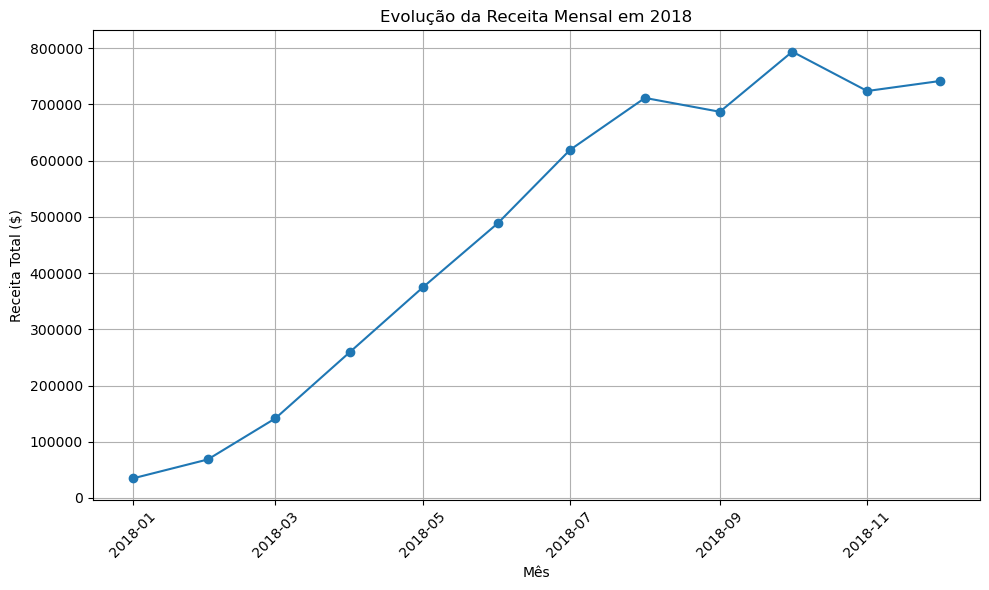

In [32]:
import matplotlib.pyplot as plt

# Plotar a evolução da receita mensal
plt.figure(figsize=(10, 6))
plt.plot(total_monthly_revenue['month'], total_monthly_revenue['revenue'], marker='o')
plt.title('Evolução da Receita Mensal em 2018')
plt.xlabel('Mês')
plt.ylabel('Receita Total ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Com base nas análises anteriores, podemos identificar alguns insights importantes para orientar as estratégias de marketing focadas em maximizar a receita da Megaline. Abaixo estão algumas recomendações específicas:

**1. Foco em Clientes Jovens e Mais Velhos (Segmentação por Idade)**

Clientes <25 e 45+ anos mostraram ser os segmentos que geram mais receita, especialmente no plano Surf.
Recomendação: Desenvolver campanhas de marketing direcionadas para esses grupos, destacando os benefícios do plano Surf. Isso pode incluir pacotes de dados extras, ofertas especiais para renovar ou aumentar a fidelidade, e parcerias com serviços populares entre esses grupos etários.

**2. Expansão em Regiões de Alta Receita (Segmentação por Localização)**

Cidades como Albany-Schenectady-Troy, NY e Albuquerque, NM têm uma receita significativamente alta, especialmente no plano Surf.
Recomendação: Concentrar esforços de marketing nessas regiões, talvez oferecendo promoções locais ou eventos que aumentem a visibilidade da marca. Campanhas personalizadas que atendam às necessidades específicas dessas áreas podem também ser eficazes.

**3. Promoção de Planos de Dados**

A análise de sensibilidade mostrou que a receita é mais sensível a variações no uso de dados. Aumentos no uso de dados resultam em aumentos significativos na receita.
Recomendação: Incentivar o uso de dados através de campanhas que promovam streaming de vídeos, jogos online, e outros serviços de alta demanda por dados. Oferecer pacotes de dados adicionais a um preço reduzido, ou promoções que oferecem "dados ilimitados durante a noite" pode aumentar o uso geral.

**4. Incentivar o Upgrade para o Plano Ultimate**

Apesar do plano Surf gerar mais receita, o plano Ultimate pode ser mais atraente para usuários que fazem uso intensivo de minutos e mensagens, pois oferece maiores limites.
Recomendação: Criar campanhas de upgrade que destacam o valor do plano Ultimate para usuários atuais do plano Surf que estão perto de exceder seus limites. Oferecer um período de teste gratuito ou um desconto no primeiro mês ao mudar para o Ultimate pode incentivar esse upgrade.

**5. Programas de Fidelidade e Incentivos**

Para manter os clientes de alto valor e incentivar a renovação contínua, implementar programas de fidelidade que recompensam os clientes com dados extras, descontos em serviços adicionais, ou benefícios em parceiros pode ser muito eficaz.
Recomendação: Introduzir um programa de fidelidade que acumule pontos por cada mês de assinatura, permitindo que os clientes troquem esses pontos por vantagens, como minutos adicionais, pacotes de dados, ou descontos em dispositivos.

**6. Campanhas Sazonais**

A análise temporal mostrou picos de receita em determinados meses. Aproveitar esses insights para criar campanhas sazonais pode ajudar a maximizar a receita nesses períodos.
Recomendação: Desenvolver campanhas promocionais para datas específicas, como férias de verão ou eventos esportivos, onde o uso de dados tende a aumentar, pode capitalizar essas tendências.

**7. Otimização do Preço do Excedente**

Considerando a sensibilidade da receita ao uso de dados e minutos, revisar e ajustar os preços para excedentes pode ser uma estratégia para otimizar a receita.
Recomendação: Realizar testes A/B com diferentes níveis de preço para excedentes e ajustar conforme necessário para maximizar a receita sem desencorajar o uso.

**Conclusão:**

Essas recomendações combinam estratégias baseadas em segmentação demográfica, geográfica e comportamental, além de ajustes nos produtos e preços. Implementar essas estratégias pode ajudar a Megaline a maximizar sua receita e fortalecer sua posição no mercado.